In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import re
import gzip

import matplotlib

font = {'family' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
matplotlib.rc('text',  usetex=True)


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
TS_START=2000
TS_END=2200

NUM_SAMPLES=float(1<<10)
NOISE_FLOOR=-92
INDEX="time"

CCA=-90
CCA_OVERRIDE={}

In [3]:
from enum import Enum
    
class Chanspec:
    WL_CHANSPEC_CHAN_MASK=0x00ff

    WL_CHANSPEC_BW_MASK=0x3800
    class Bandwidth(Enum):
        WL_CHANSPEC_BW_5=0x0000
        WL_CHANSPEC_BW_10=0x0800
        WL_CHANSPEC_BW_20=0x1000
        WL_CHANSPEC_BW_40=0x1800
        WL_CHANSPEC_BW_80=0x2000
        WL_CHANSPEC_BW_160=0x2800
        WL_CHANSPEC_BW_8080=0x3000
    
    WL_CHANSPEC_BAND_MASK=0xc000
    class Band(Enum):
        WL_CHANSPEC_BAND_2G=0x0000
        WL_CHANSPEC_BAND_3G=0x4000
        WL_CHANSPEC_BAND_4G=0x8000
        WL_CHANSPEC_BAND_5G=0xc000
        
    def __init__(self,chanspec):
        self.channel=chanspec&self.WL_CHANSPEC_CHAN_MASK
        self.bandwidth=self.Bandwidth(chanspec&self.WL_CHANSPEC_BW_MASK)
        self.band=self.Band(chanspec&self.WL_CHANSPEC_BAND_MASK)
        
    def __repr__(self):
        return "Channel: %d, Bandwidth %s, Band %s"%(self.channel,self.bandwidth.name,self.band.name)

WL_CHANSPEC_BAND_SHIFT=14

In [4]:
dfs={}
load={}

load["pi1"]="rpi93/rssi-1588775159.csv.gz"
load["pi2"]="rpi91/rssi-1588775153.csv.gz"
load["pi3"]="rpi92/rssi-1588775155.csv.gz"
load["pi4"]="rpi94/rssi-1588775160.csv.gz"
load["pi5"]="rpi90/rssi-1588775155.csv.gz"

for key in load.keys():
    with gzip.GzipFile(load[key]) as decompressedFile:
        print("%s: %s"%(key,load[key]))
        dfs[key]=pd.read_csv(decompressedFile,parse_dates=["time"],index_col=0)
        chanspec=Chanspec(dfs[key].iloc[0].chanspec)
        print("%s: %s"%(key,chanspec))   

pi1: rpi93/rssi-1588775159.csv.gz


/home/schuschu/jupyter/venv3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


pi1: Channel: 7, Bandwidth WL_CHANSPEC_BW_20, Band WL_CHANSPEC_BAND_2G
pi2: rpi91/rssi-1588775153.csv.gz
pi2: Channel: 7, Bandwidth WL_CHANSPEC_BW_20, Band WL_CHANSPEC_BAND_2G
pi3: rpi92/rssi-1588775155.csv.gz
pi3: Channel: 7, Bandwidth WL_CHANSPEC_BW_20, Band WL_CHANSPEC_BAND_2G
pi4: rpi94/rssi-1588775160.csv.gz
pi4: Channel: 7, Bandwidth WL_CHANSPEC_BW_20, Band WL_CHANSPEC_BAND_2G
pi5: rpi90/rssi-1588775155.csv.gz
pi5: Channel: 7, Bandwidth WL_CHANSPEC_BW_20, Band WL_CHANSPEC_BAND_2G


In [5]:
nfs={}
for key in dfs.keys():
    df=dfs[key]
    nfs[key]=df.copy()
    nfs[key]["power"]=(df["power"]/NUM_SAMPLES)+NOISE_FLOOR

In [6]:
offset_time=None

zfs={}
mfs={}
for key in nfs.keys():
    zfs[key]=nfs[key].copy(deep=True)
    if offset_time==None:
        offset_time=zfs[key]["time"].iloc[0]
    zfs[key]["time"]-=offset_time
    zfs[key]["tsf"]-=zfs[key]["tsf"].iloc[0]
    zfs[key]["time"]=zfs[key]["time"].dt.total_seconds()*1e3
    zfs[key]["tsf"]=zfs[key]["tsf"]/1e3
    zfs[key]=zfs[key].set_index(INDEX,drop=True)
    zfs[key]=zfs[key][TS_START:TS_END]

    mfs[key]=zfs[key].copy(deep=True)
    MAX_VAL=zfs[key]["power"].max()
    MIN_VAL=zfs[key]["power"].min()
    
    pf=mfs[key].power.copy(deep=True)
    if key in CCA_OVERRIDE:
        TCCA=CCA_OVERRIDE[key]
    else:
        TCCA=CCA
    pf[pf > TCCA]=MAX_VAL
    pf[pf <= TCCA]=MIN_VAL
    mfs[key]["power"]=pf

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


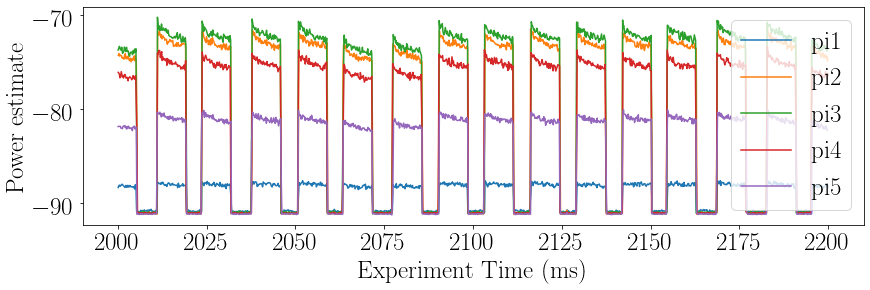

<Figure size 432x288 with 0 Axes>

In [7]:
plt.figure()
ax=None

for key in zfs.keys():
    if ax==None:
        ax=zfs[key]["power"].plot()
    else:
        ax=zfs[key]["power"].plot(ax=ax,figsize=(14,4))
ax.legend(mfs.keys());
ax.set_ylabel("Power estimate");
ax.set_xlabel("Experiment Time (ms)");

plt.figure()
ax=None

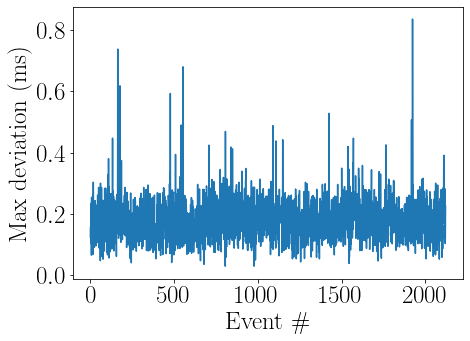

In [8]:
DTS_START=41000
DTS_END=69000

delta_offset_time=None

dzfs={}
dmfs={}
for key in nfs.keys():
    dzfs[key]=nfs[key].copy(deep=True)
    if delta_offset_time==None:
        delta_offset_time=dzfs[key]["time"].iloc[0]
    dzfs[key]["time"]-=delta_offset_time
    dzfs[key]["tsf"]-=dzfs[key]["tsf"].iloc[0]
    dzfs[key]["time"]=dzfs[key]["time"].dt.total_seconds()*1e3
    dzfs[key]["tsf"]=dzfs[key]["tsf"]/1e3
    dzfs[key]=dzfs[key].set_index(INDEX,drop=True)
    dzfs[key]=dzfs[key][DTS_START:DTS_END]

    dmfs[key]=dzfs[key].copy(deep=True)
    MAX_VAL=dzfs[key]["power"].max()
    MIN_VAL=dzfs[key]["power"].min()
    
    pf=dmfs[key].power.copy(deep=True)
    if key in CCA_OVERRIDE:
        TCCA=CCA_OVERRIDE[key]
    else:
        TCCA=CCA
    pf[pf > TCCA]=MAX_VAL
    pf[pf <= TCCA]=MIN_VAL
    dmfs[key]["power"]=pf

delta_dfs={}

for key in mfs.keys():
    xf=dmfs[key].reset_index(drop=False)
    sf=xf.diff().dropna()
    sf=sf.reset_index(drop=False)
    sf=sf[sf["power"] != 0]
    sf=sf[sf["power"] > 0]
    sf=xf.iloc[sf.index]
    delta_dfs[key]=sf.time.reset_index(drop=True)

ddfs=pd.DataFrame(delta_dfs)
ddfs_var=ddfs.var(axis=1)
ddfs_std=ddfs.std(axis=1)
ddfs_diff=ddfs.max(axis=1)-ddfs.min(axis=1)
ddfs_mean=ddfs.mean(axis=1)

ddfs["var"]=ddfs_var
ddfs["std"]=ddfs_std
ddfs["mean"]=ddfs_mean
ddfs["diff"]=ddfs_diff
plt.figure()
ax=ddfs["diff"].plot(figsize=(7,5),title="")
ax.set_ylabel("Max deviation (ms)")
ax.set_xlabel("Event \#");

Text(0, 0.5, 'Relative offset (ms)')

<Figure size 432x288 with 0 Axes>

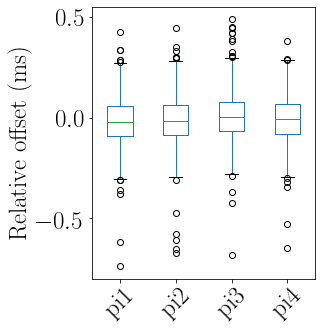

In [9]:
FIXEDPI="pi5"
bffs=pd.DataFrame()
for key in zfs.keys():
    if key==FIXEDPI:
        continue
    bffs[key]=ddfs[key]-ddfs[FIXEDPI]

plt.figure()
ax=bffs.plot(kind="box",figsize=(4,5),title="",rot=45)
ax.set_ylabel("Relative offset (ms)")

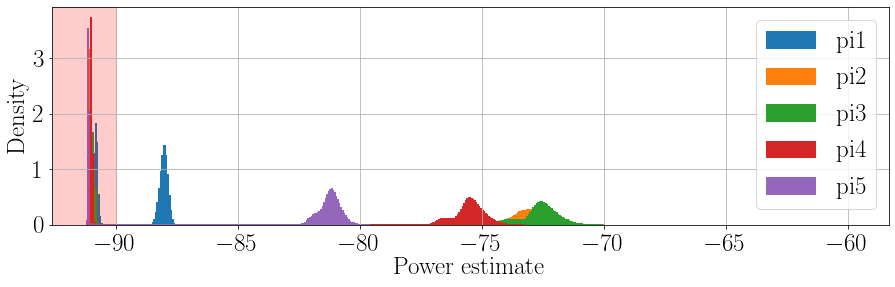

In [10]:
plt.figure()
ax=None

for key in nfs.keys():

    if ax==None:
        ax=nfs[key]["power"].hist(bins=512,log=False,range=(-93,-60),density=True)
    else:
        ax=nfs[key]["power"].hist(ax=ax,log=False,bins=512,figsize=(15,4),range=(-93,-60),density=True)

ax.set_ylabel("Density");
ax.set_xlabel("Power estimate");
(l,r)=ax.get_xlim()
ax.set_xlim((l+2,r))
mkfunc = lambda x, pos: '%1.0fM' % (x * 1e-6) if x >= 1e6 else '%1.0fK' % (x * 1e-3) if x >= 1e3 else '%1.0f' % x
mkformatter = matplotlib.ticker.FuncFormatter(mkfunc)
ax.yaxis.set_major_formatter(mkformatter)
ax.legend(nfs.keys())
plt.axvspan(-93, -90, color='red', alpha=0.2);